# Heuristics for compressive sensing 

## Sparse recovery

### Orthogonal matching pursuit

In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
from matplotlib import pyplot as plt

Generate a true signal and uncorrupted undertermined linear observation. 

In [2]:
x = np.zeros(200)
x[np.random.choice(200, 4)] = np.random.normal(scale=0.5, size = 4)

A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

y = A @ x

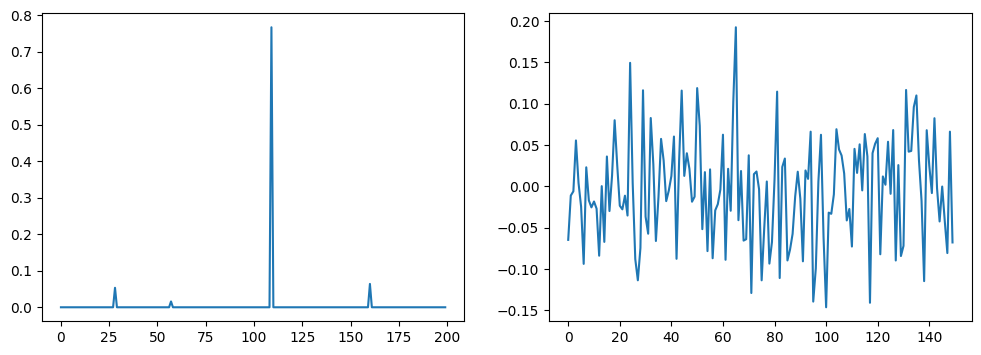

In [7]:
_, axs = plt.subplots(1,2, figsize =(12,4))
axs[0].plot(x)
axs[1].plot(y)

In [13]:
def ortho_match_pursuit(y, A, max_iter = 10, eps = 1e-2):
    S = []

    x = np.zeros(A.shape[1])
    iters = 0
    rate = 0
    R = y

    while iters < max_iter or rate > eps:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.abs(A.T @ R)))

        dic = A[:,S]
        x[S] = np.linalg.pinv(dic.T @ dic) @ dic.T @ y
        
        # Update the residuals
        R = y - A @ x
        iters += 1

    return x

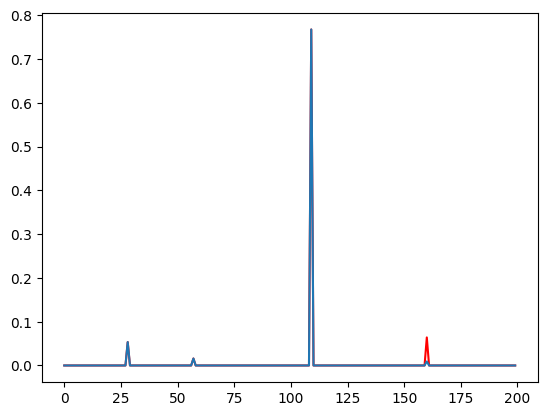

In [14]:
plt.plot(x, color='red')
plt.plot(ortho_match_pursuit(y,A))

Take home message: orthogonality is yielded by construction considering many basis (canonic, Fourier, Legendre...): just consider orthogonality as a synonim for "diversity" between different symbols. 

### Iterative hard thresholding

In [10]:
# Subroutine for learned sparsity - IHS

def Hs(x, s):
    '''
    Hard thresholding operator keeps the s highest in magnitude component of a vector and collapse to zero all the others
    '''

    # Retrieve the indeces of s highest in magnitude components of x (argsort is increasing so [:-s] keeps the s highest ones)
    idxs = np.argsort(np.abs(x))[-s:]

    # Initialize an all zeros vector and store the retrieved component of x in the corresponding indices
    X = np.zeros(x.shape[0])
    X[idxs] = x[idxs]
    return X

def iterative_hard_thresholding(y, A, s):
    x = np.zeros(A.shape[1])
    iters = 0

    while iters < s:

        # Apply the hard thresholding in a fixed point fashion
        x = Hs(x + A.T @ (y - A @ x), s)
        iters += 1

    return x

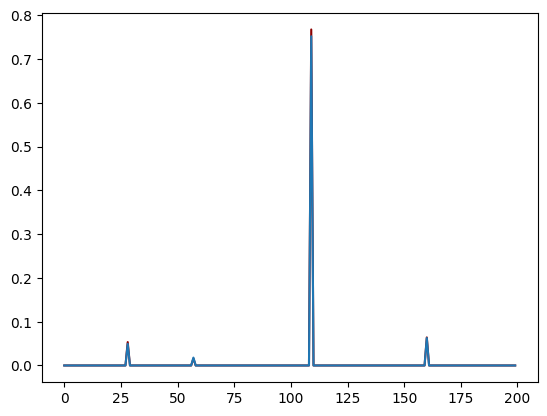

In [12]:
plt.plot(x, color = 'darkred')
plt.plot(iterative_hard_thresholding(y,A,4))

## Singular Value Thresholding for matrix completion 

In [10]:
n1 = 1682
n2 = 943
m = 4e5

In [11]:
print(f"The undersampling factor is {m/(n1*n2)}")

The undersampling factor is 0.25218677456898125


In [12]:
M = np.random.choice(np.array([1,2,3,4,5]),size=(n1,n2))

In [13]:
# Low ranking M (r = 10)
U, sigma, V = np.linalg.svd(M, full_matrices=False)
sigma[10:] = 0
sigma = np.diag(sigma)
M = U@sigma@V

In [14]:
# Defining random samples 
Omega = np.zeros(n1*n2)
Omega[:int(m)] = 1
np.random.shuffle(Omega)
Omega = np.reshape(Omega, newshape=(n1,n2))

In [15]:
M_ = M*Omega

In [18]:
def D_tau(A, tau):
    U, sigma, V = np.linalg.svd(A, full_matrices=False)
    sigma = np.diag(sigma-tau)
    sigma = np.maximum(sigma, np.zeros_like(sigma))
    return U@sigma@V

In [19]:
def SVT(tau, M, max_iter = 200):
    delta = 1.2*M.shape[0]*M.shape[1]/np.sum(M != 0)
    Y = np.zeros(M.shape)
    P_omega = (M != 0)
    for _ in tqdm(range(max_iter)):
        delta = np.maximum(delta*0.99, 1)
        X = D_tau(Y, tau)
        Y += delta*P_omega*(M - X)
    return X

In [30]:
M_hat = SVT(1000, M_, 200)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [05:50<00:00,  1.75s/it]


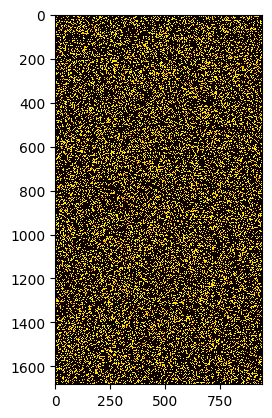

In [31]:
plt.imshow(M_, cmap='hot', interpolation='nearest')

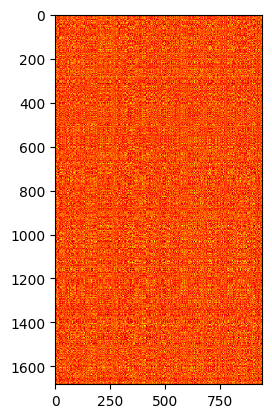

In [32]:
plt.imshow(M, cmap='hot', interpolation='nearest')

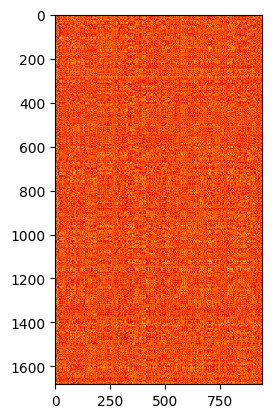

In [33]:
plt.imshow(M_hat, cmap='hot', interpolation='nearest')

In [34]:
np.linalg.norm(M - M_hat, ord='fro')

0.3972985932890211